# 
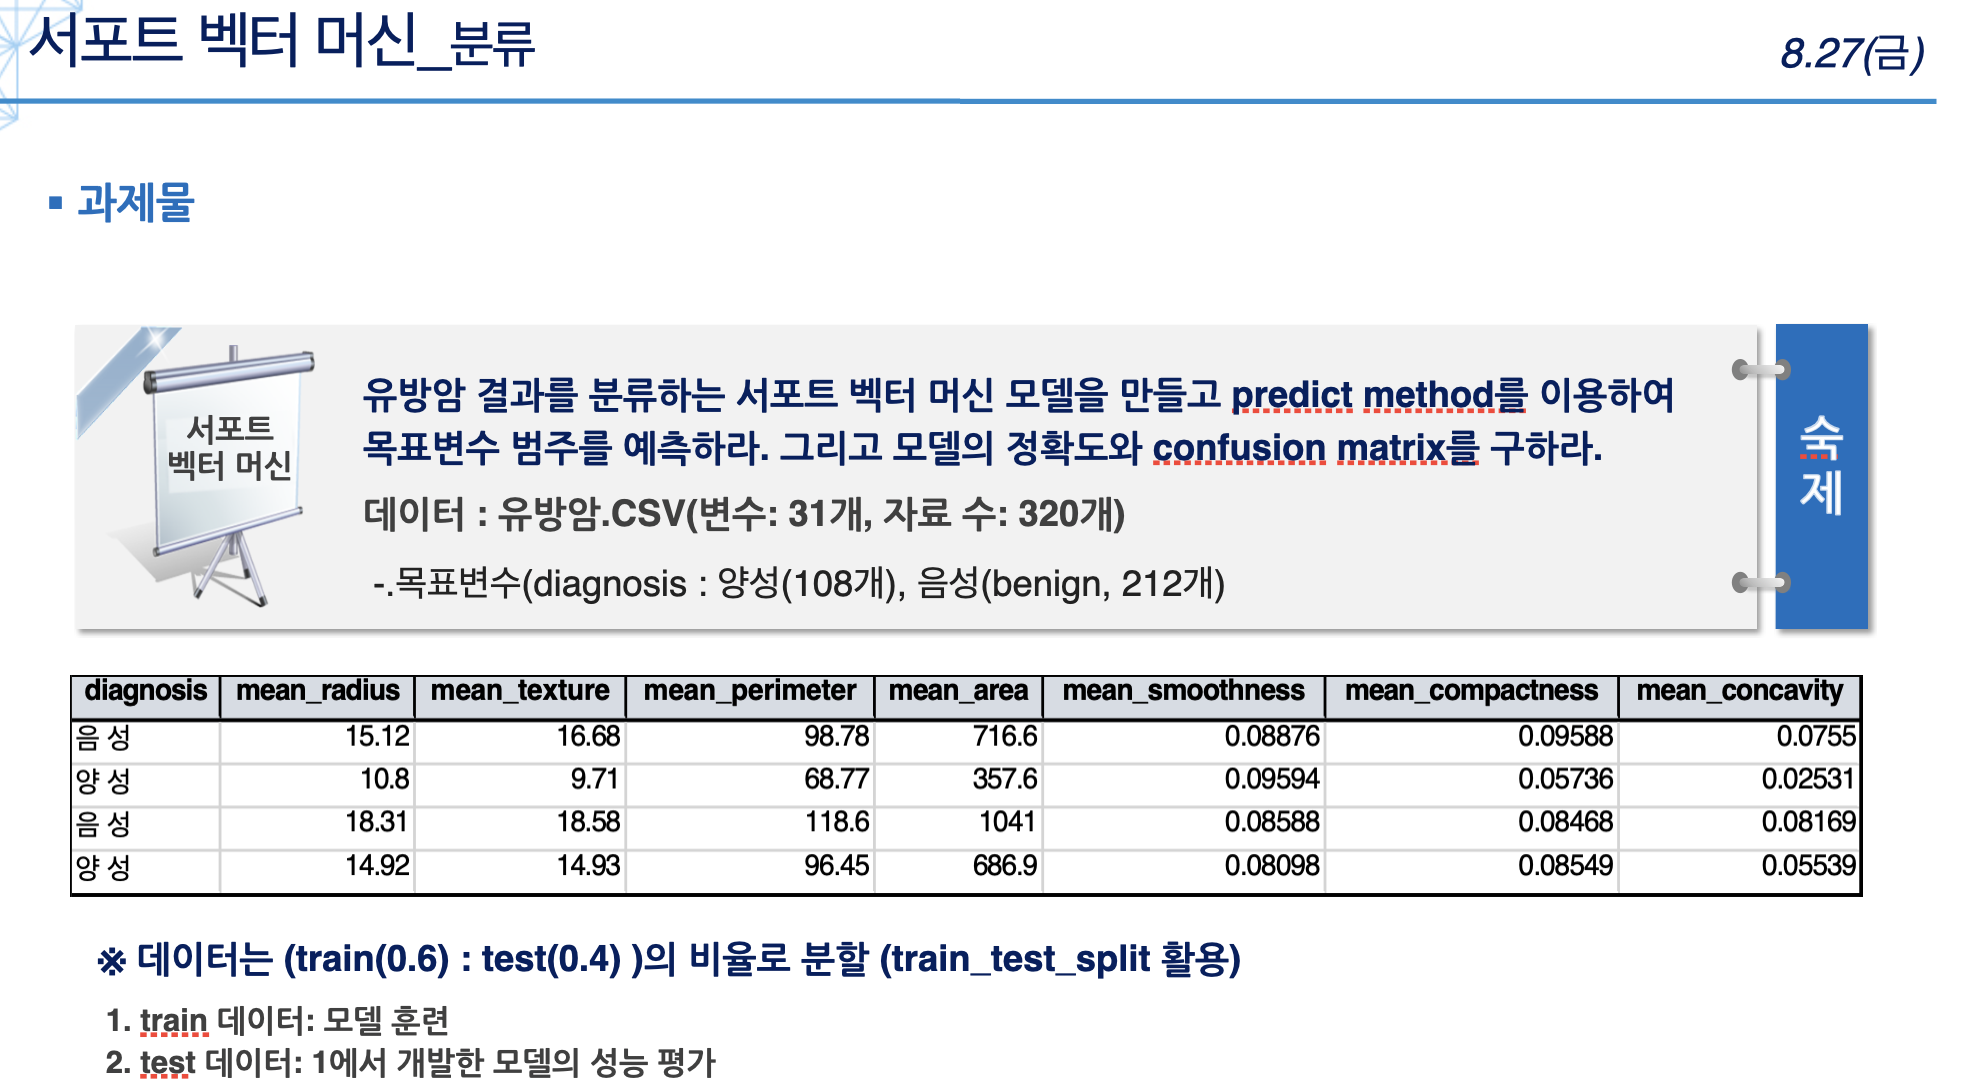

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import SVC


# 1.데이터 불러오기

In [5]:
## 데이터 구성하기
df_raw = pd.read_csv('../data/유방암.csv', engine='python', encoding='cp949')
df_raw.head(n=3)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.1491,0.3331,0.3327,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.1436,0.1257,0.1047,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.1234,0.2445,0.3538,0.15710,0.3206,0.06938


# 2.데이터 전처리: object형 목표변수를 숫자형으로 변경 

In [6]:
df_raw.replace({'diagnosis': '양성'}, 1, inplace=True)
df_raw.replace({'diagnosis': '음성'}, 0, inplace=True)

df_raw_y=df_raw["diagnosis"]
df_raw_x=df_raw.drop("diagnosis",axis=1,inplace=False)

# train, test 데이터 생성
## randomstate(초기 자료 선택 기준)를 100으로 변경


### 이유:
Cost에 따른 accuracy 변화 실험시,

randomstate=1234로 분류한 train, test 데이터로 모델을 학습하면 test데이터 train데이터보다 높은 구간이 존재합니다.


이 문제를 해결하기 위해, randomstate(초기 자료 선택 기준)를 100으로 변경하여 다른 train, test 데이터를 선택하고, SVC 모델을 학습하기로 결정했습니다.

In [7]:
# 데이터 구성하기 - 데이터 분할
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=100)
print("train data X size :{}".format(df_train_x.shape))
print("train data Y size :{}".format(df_train_y.shape))
print("test data X size :{}".format(df_test_x.shape))
print("test data Y size :{}".format(df_test_y.shape))

train data X size :(224, 30)
train data Y size :(224,)
test data X size :(96, 30)
test data Y size :(96,)


# 3. SVC 모델 생성



## hyper parameter 튜닝 전 모델 정확도

#### randomstate(초기 자료 선택 기준)를 100으로 변경

Accuracy on svm_uncustomized training set:0.902
Accuracy on svm_uncustomized test set:0.875

In [8]:
svm_uncustomized=SVC(random_state=100)
svm_uncustomized.fit(df_train_x,df_train_y)

#train 데이터 정확도
print("Accuracy on svm_uncustomized training set:{:.3f}".format(svm_uncustomized.score(df_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm_uncustomized test set:{:.3f}".format(svm_uncustomized.score(df_test_x,df_test_y)))

Accuracy on svm_uncustomized training set:0.902
Accuracy on svm_uncustomized test set:0.875


# 4-1. 모델 파라메터 조정 1: Cost =>0.8선택

## 4-1-1. Cost(0.01~10)에 따른 accuracy 변화


cost가 1이하인 경우 train, test 정확도가 급격히 높아진다. 


cost가 1이상인 경우 모델 정확도는 train 데이터에 과적합 되고, test 데이터에 변화가 없다.


따라서 cost가 1이하인 구간에 대한 추가 조사를 통해 파라메터를 선정하였습니다.

Cost = 0.8에서 train, test 정확도 차이가 작기 때문에 선정하였습니다.


In [9]:
train_accuracy = []; test_accuracy =[]
para_c = [10**c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C=v_C,random_state=100)
    svm.fit(df_train_x,df_train_y)
    train_accuracy.append(svm.score(df_train_x,df_train_y))
    test_accuracy.append(svm.score(df_test_x,df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["Train Accuracy"]=train_accuracy
df_accuracy_c["Test Accuracy"]=test_accuracy

In [10]:
df_accuracy_c.round(3)

,C,Train Accuracy,Test Accuracy
0,0.01,0.665,0.656
1,0.10,0.893,0.865
2,1.00,0.902,0.875
3,10.00,0.929,0.865


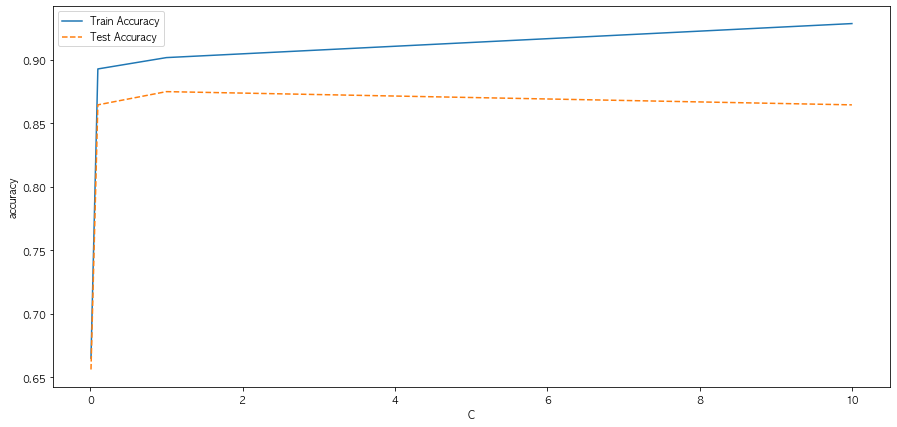

In [11]:
plt.figure(figsize=(15,7))
plt.plot(para_c,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
# plt.axvline(x=1, linestyle='--', c='r', label='주성분 2번')
plt.ylabel("accuracy");plt.xlabel("C")
plt.legend()

## 4-1-2. Cost (0.1~2)에 따른 accuracy 변화

Cost = 0.8에서 train, test 정확도 차이가 작기 때문에 선정하였습니다.


In [12]:
train_accuracy = []; test_accuracy =[]
para_c = [c*0.1 for c in range(1,20)]

for v_C in para_c:
    svm = SVC(C=v_C,random_state=100)
    svm.fit(df_train_x,df_train_y)
    train_accuracy.append(svm.score(df_train_x,df_train_y))
    test_accuracy.append(svm.score(df_test_x,df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["Train Accuracy"]=train_accuracy
df_accuracy_c["Test Accuracy"]=test_accuracy

In [13]:
df_accuracy_c.round(3)

,C,Train Accuracy,Test Accuracy
0,0.1,0.893,0.865
1,0.2,0.897,0.875
2,0.3,0.897,0.875
3,0.4,0.902,0.875
4,0.5,0.902,0.875
5,0.6,0.902,0.875
6,0.7,0.902,0.875
7,0.8,0.897,0.875
8,0.9,0.902,0.875
9,1.0,0.902,0.875


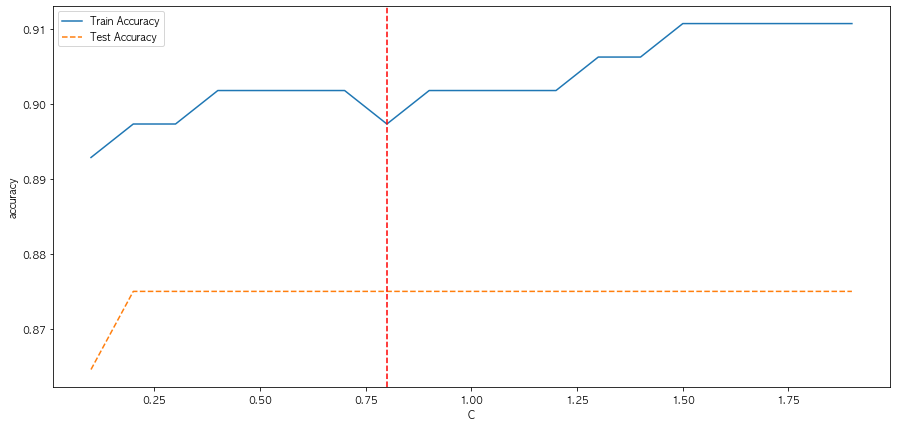

In [14]:
plt.figure(figsize=(15,7))
plt.plot(para_c,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
plt.axvline(x=0.8, linestyle='--', c='r')
plt.ylabel("accuracy");plt.xlabel("C")
plt.legend()

# 4-2.모델 파라메터 조정 2: gamma =>영향 없으므로 default 값 선택

- gamma파라메터란?

gamma는 데이터의 영향력의 거리와 반비례관계이다.

gamma가 클수록 1개 데이터의 영향력 거리가 짧아져 과적합 위험이 있다.

- 선택 이유

gamma에 따른 train, tset 정확도의 변화가 없다.



### SVC 모델의 default 설정값 확인

In [22]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## 4-2-1. gamma(0.01~10)에 따른 accuracy 변화


In [35]:
train_accuracy = []; test_accuracy =[]
para_gamma = [10**gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=0.8,random_state=100)
    svm.fit(df_train_x,df_train_y)
    train_accuracy.append(svm.score(df_train_x,df_train_y))
    test_accuracy.append(svm.score(df_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

In [36]:
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,1.0,0.6562
1,0.10,1.0,0.6562
2,1.00,1.0,0.6562
3,10.00,1.0,0.6562


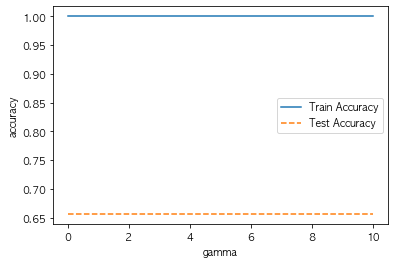

In [14]:
plt.plot(para_gamma,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_gamma,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

# 5.Scale 변환

## 필요성:
SVM은 변수간 거리를 기반으로 데이터 군을 나누는 방법이므로,

변수간 scale 차이가 큰 경우 결과 도출에 영향을 줄 수 있다.

따라서 설명변수 값의 구간을 동일하게 변환하는 Standardscaler를 적용하였다.

### Scale 변환 결과: 평균이 0,  표준편차가 1로 변환된 것을 알 수 있다.

In [15]:
v_feature_name = df_train_x.columns
scaler = StandardScaler()
df_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(df_scaled,columns=v_feature_name)
df_scaled.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,...,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02
mean,2.532696e-16,-6.522560e-16,-2.844947e-16,7.320533e-17,1.131734e-15,-4.649059e-17,1.131040e-16,-1.651457e-16,4.066192e-16,8.829742e-16,...,1.644518e-16,1.130866e-15,3.129441e-16,-6.661338e-17,-1.204592e-15,1.346145e-16,-7.910339e-17,-1.644518e-16,1.713907e-16,1.817990e-16
std,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,...,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00
min,-2.144078e+00,-2.560965e+00,-2.137206e+00,-1.628531e+00,-3.284486e+00,-1.689536e+00,-1.442260e+00,-1.607458e+00,-2.163524e+00,-1.771699e+00,...,-1.906495e+00,-2.517236e+00,-1.914321e+00,-1.421712e+00,-2.234131e+00,-1.476710e+00,-1.648315e+00,-2.165421e+00,-2.145534e+00,-1.602209e+00
25%,-7.111638e-01,-6.908989e-01,-7.057591e-01,-7.252621e-01,-6.409206e-01,-7.374164e-01,-8.191610e-01,-8.985510e-01,-7.241279e-01,-7.283403e-01,...,-7.508361e-01,-6.540078e-01,-7.714095e-01,-7.499304e-01,-6.445040e-01,-7.341324e-01,-7.938634e-01,-8.129523e-01,-6.699070e-01,-6.825086e-01
50%,-1.563406e-01,-2.612060e-02,-1.143788e-01,-2.419430e-01,-5.541402e-02,-1.392174e-01,-1.333628e-01,-4.108234e-02,-7.731061e-02,-1.718356e-01,...,-1.570138e-01,-5.721191e-02,-1.217590e-01,-2.566707e-01,1.596124e-02,-1.815506e-01,-6.154336e-02,1.073604e-01,-1.342341e-01,-2.252776e-01
75%,7.514302e-01,5.252472e-01,7.171588e-01,6.835562e-01,6.109248e-01,5.672238e-01,5.597562e-01,5.952241e-01,5.804388e-01,5.608839e-01,...,7.494228e-01,6.144939e-01,7.138043e-01,6.328921e-01,5.808470e-01,5.542250e-01,6.106452e-01,7.682083e-01,3.324944e-01,5.282929e-01
max,3.315649e+00,4.574242e+00,3.312564e+00,4.326655e+00,4.501416e+00,3.889336e+00,3.597318e+00,3.221391e+00,4.271853e+00,4.842278e+00,...,3.381761e+00,3.694077e+00,3.564468e+00,4.876011e+00,3.647983e+00,4.282831e+00,3.816063e+00,2.165812e+00,5.179179e+00,6.003840e+00


## Scale 변환 이전 데이터와, cost=0.8로 학습한 모델의 정확도

In [25]:
svm_original = SVC(C=0.8,random_state=100)
svm_original.fit(df_train_x,df_train_y)

#train 데이터 정확도
print("Accuracy on svm scale 이전 training set:{:.3f}".format(svm_original.score(df_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm scaled 이전 test set:{:.3f}".format(svm_original.score(df_test_x,df_test_y)))

Accuracy on svm scale 이전 training set:0.897
Accuracy on svm scaled 이전 test set:0.875


# 6.Scale 변환된 데이터로 SVM 모델 생성
## Scale 변환된 데이터로 train, test 데이터 생성

## 모델 정확도

scale을 적용한 데이터의 train 정확도는 0.987으로 scale변환 전 0.897보다 증가,

scale을 적용한 데이터의 test 정확도는 0.969 scale변환 전 0.875보다 증가하였다.

In [18]:
df_scaled_train_x, df_scaled_test_x, = train_test_split(df_scaled, test_size = 0.3, random_state=100)
print("train data X szie {}".format(df_scaled_train_x.shape))
print("test data Y szie {}".format(df_scaled_test_x.shape))

train data X szie (224, 30)
test data Y szie (96, 30)


In [24]:
svm_scaled = SVC(random_state=100)
svm_scaled.fit(df_scaled_train_x,df_train_y)
#train 데이터 정확도
print("Accuracy on svm scale 이후 training set:{:.3f}".format(svm_scaled.score(df_scaled_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm_scale 이후 test set:{:.3f}".format(svm_scaled.score(df_scaled_test_x,df_test_y)))

Accuracy on svm scale 이후 training set:0.987
Accuracy on svm_scale 이후 test set:0.969


# 7-1. 모델 파라메터 조정: Cost =>1선택
train, test 정확도가 95% 이상으로 높고 train, test 정확도 차이가 작은 1 선택

In [60]:
train_accuracy = []; test_accuracy =[]
para_c = [10**c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C=v_C,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"]=train_accuracy
df_accuracy_c["TestAccuracy"]=test_accuracy

In [61]:
df_accuracy_c.round(4)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.6652,0.6562
1,0.10,0.9375,0.9271
2,1.00,0.9866,0.9688
3,10.00,1.0000,0.9688


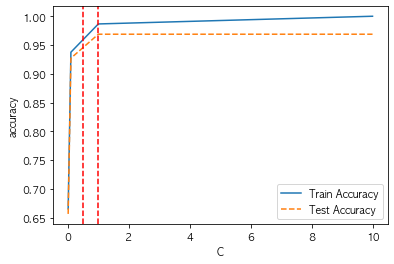

In [62]:
plt.plot(para_c,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("C")
plt.axvline(x=1, linestyle='--', c='r')
plt.axvline(x=0.5, linestyle='--', c='r')

plt.legend()

# 7-2.모델 파라메터 조정 : gamma =>영향 없으므로 default 값 선택

gamma가 증가하면서 test 정확도가 급격히 감소하므로 0.1을 선택했습니다.

## 7-2-1. gamma(0.01~10)에 따른 accuracy 변화


In [41]:
train_accuracy = []; test_accuracy =[]
para_gamma = [10**gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=1,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

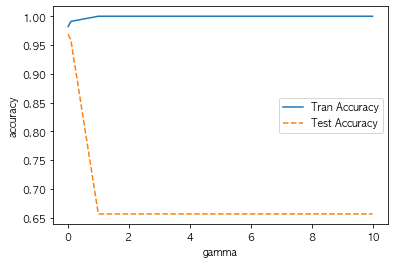

In [42]:
df_accuracy_c.round(3)
plt.plot(para_c,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

## 7-2-2. gamma(0.1~0.5)에 따른 accuracy 변화
gamma가 증가하면서 test 정확도가 급격히 감소하므로 0.1을 선택했습니다.

In [51]:
train_accuracy = []; test_accuracy =[]
para_gamma = [gamma*0.1 for gamma in range(1,5)]


for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=1,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

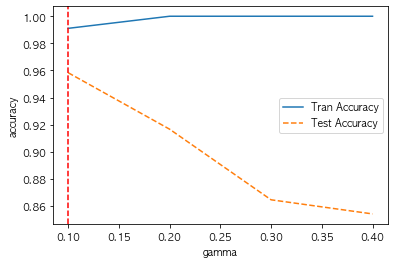

In [53]:
df_accuracy_c.round(3)
plt.plot(para_gamma,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_gamma,test_accuracy,linestyle='--',label="Test Accuracy")
plt.axvline(x=0.1, linestyle='--', c='r')
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

# 8.최종 모델: 하이퍼 파라메터 ( C =0.8, gamma=0.1 )

# 최종 모델 평가

## 📌해석: 정확도

C, gamma 파라메터 튜닝한 SVM 모델의 test 정확도는 95.8%으로 튜닝 전 96.9%보다 1.1% 감소하였다.

C, gamma 파라메터 튜닝한 SVM 모델은 RandomForest 모델의 test 정확도 95.5%보다 0.3% 증가하였다.



## 📌해석: f1-score
목표 변수 1기준 f1-score은 0.937으로 RandomForest 모델 결과인 0.833보다 증가하였다.

## 📌결론: 
#### C, gamma 파라메터 튜닝한 SVM 모델이 RandomForest 모델보다 Accuracy와 f1-score이 높으므로 유방암 양성 진단에 더 좋은 모델이다.


In [63]:
svc_final = SVC(gamma=0.1,C=0.8,random_state=100)
svc_final.fit(df_scaled_train_x,df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)
print("Accuracy on training set:{:.3f}".format(svc_final.score(df_scaled_train_x,df_train_y)))
print("Accuracy on test set:{:.3f}".format(svc_final.score(df_scaled_test_x,df_test_y)))
print("\nAccuracy on test set\n:{}".format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy on training set:0.991
Accuracy on test set:0.958

Accuracy on test set
:[[62  1]
 [ 3 30]]
              precision    recall  f1-score   support

           0      0.954     0.984     0.969        63
           1      0.968     0.909     0.937        33

    accuracy                          0.958        96
   macro avg      0.961     0.947     0.953        96
weighted avg      0.959     0.958     0.958        96



## GridSearchCV를 통한 Hyperparemter 탐색과 모델 정확도
제가 설정한  파라메터와 같은 점은 gamma=0.1이며,

다른 점은 다른 C=10인 것입니다.

In [55]:
estimaotr = SVC(random_state=100)
param_grid={"C":para_c,"gamma":para_gamma}
grid_rf=GridSearchCV(estimaotr,param_grid,scoring="accuracy",n_jobs=-1)
grid_rf.fit(df_scaled_train_x,df_train_y)
print("best estimator model:\n{}".format(grid_rf.best_estimator_))
print("\nbest parameter:\n{}".format(grid_rf.best_params_))
print("\nbest score \n{}".format(grid_rf.best_score_.round(3)))

best estimator model:
SVC(C=10, gamma=0.1, random_state=100)

best parameter:
{'C': 10, 'gamma': 0.1}

best score 
0.933
